<a href="https://colab.research.google.com/github/oskarrrrvk/VisionTransformer_notebook/blob/main/Pr%C3%A1ctica_3_Transformers_Modificado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3 - Transformers

En esta práctica deberéis modificar el código empleado durante el ejemplo de implementación de un Vision Transformer de forma que, ahora sí, se incluya el `[class] embedding` que no incluímos en el ejemplo.

Para ello, os recomiendo encarecidamente que consultéis [este ejemplo](https://colab.research.google.com/github/dzlab/fastpages/blob/master/_notebooks/2021-10-01-vision_transformer.ipynb#scrollTo=e_QF2mpn8c19&line=1&uniqifier=1), pues os resolverá muchas dudas y os ayudará con la implementación (fijaos en el `class_token`). Sin embargo, este ejemplo añade el `[class] embedding` **al final**, y vosotros tendréis que hacerlo al principio, igual que hace el [paper original](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Farxiv.org%2Fabs%2F2010.11929).

Tras haberlo implementado, comentad los resultados indicando si habéis observado algún cambio en el comportamiento del modelo. Recordad que para que la comparación sea justa, deberéis **no modificar** nada más del código, excepto lo necesario para añadir el `[class] embedding`.

A continuación disponéis del código de la Práctica de ViT, el cual deberéis modificar y entregar en este mismo cuaderno para su evaluación.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

As described in the paper [arxiv.org](https://arxiv.org/abs/2010.11929) and depicted in the following diagram, ViT works as follows:

1. Each image is split into fixed-size patches
2. Calculate a Patch Embeddings for each patch
3. Add position embeddings a class token to each of the Patch Embeddings
4. The sequence of embeddings are passed to a Transformer encoder
5. Pass the representations through a MLP Head to get final class predictions.

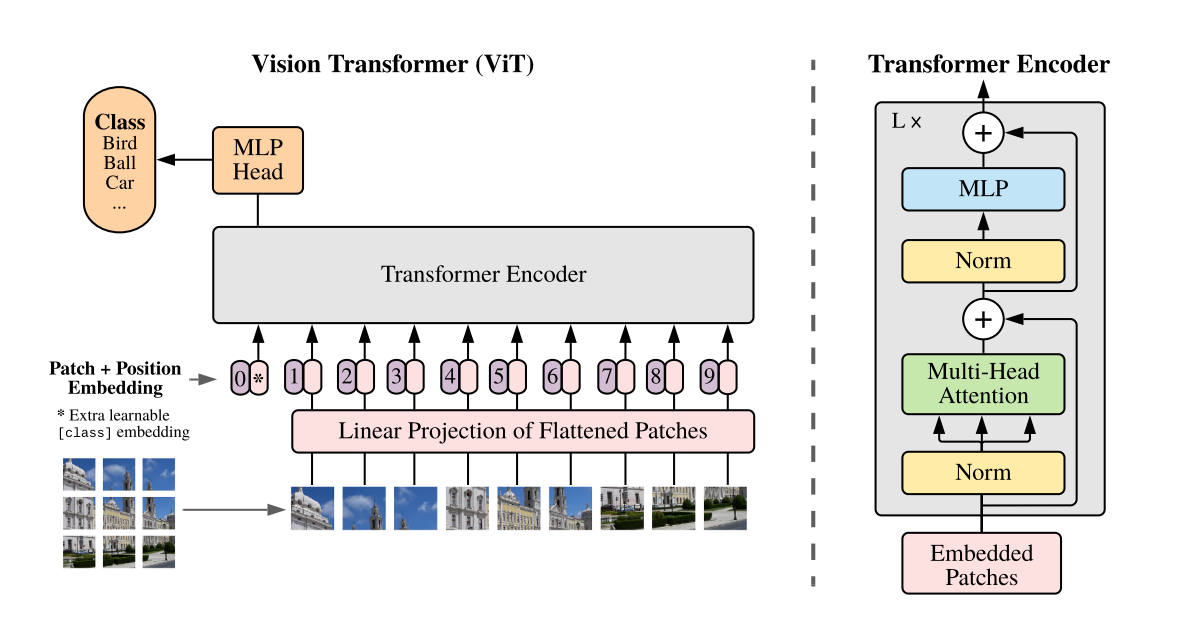

As a detailed example, when trying to classify an image (with similar size as ImageNet images: `224 x 224 x 3`), the process is as follows:


1. Divide the image into patches of size `16 x 16`. This will create `14 x 14 = 196` patches. Then, we put the patches in sequence one after the other as depicted in the diagram above.

2. Pass each of those patches through a linear layer to get an embeddings vector or **Patch Embeddings** of the patch of size `1 x 768` (note that `3 x 16 x 16 = 768`). In the diagram those vectors are colored in pink.

3. For each patch we calculate it's **Position Embeddings** (as shown in purple) and then add this vector to the previous **Patch Embeddings**.

  1. In the original paper, they also append at the begining the embeddings of the special token `[class]` (**ClassToken**). After this, they end up with a matrix of size `1 x 768 + 196 x 768 = 197 x 768`. However, we **will not do this** in this example for the sake of simplicity.

4. The patch embeddings are passed through **Transformer Encoder** to get the learned representations. The Transformer layers do not modify the shape of the data, so the output will be a `[batch_size, 197, 768]` vector.

5. The representation generated by the transformer is passed to the `MLP Head` (which is simply a `Dense` layer without any activation -- the activation is included in the loss function) to generate the class predictions.


## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [ ]:
os.environ["KERAS_BACKEND"] = "torch"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Make sure experiments are reproducible:

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(42)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.

# disabled to increase speed
# tf.config.experimental.enable_op_determinism()

## Prepare the data

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

We can define a pipeline using Data Augmentation to improve the generalization capabilities of our model. In fact, we can define it as a Keras `layer` by using `tf.keras.Sequential` and adding the transformations we wish to apply to our images.

For this example, we will be resizing the images to `72x72` pixels and using a `patch_size` of 6.

<small>NOTE: in the original paper they use an image size of `224x224` and `16x16` patches.</small>

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch creation as a layer

The first step in implementing the ViT model is the extraction of patches from an input image as depicted in the following illustration:

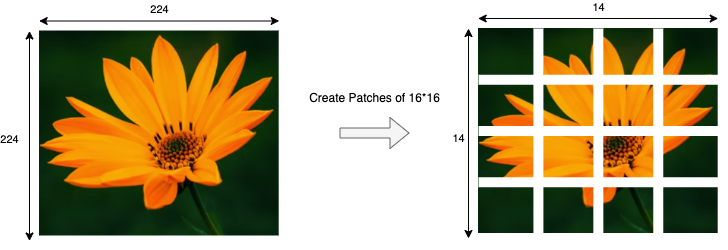

In TensorFlow, we can simply use the [tf.image.extract_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_patches) function to extract patches. We can use it inside a custom `Layer` to make it easy to use later when building the model

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


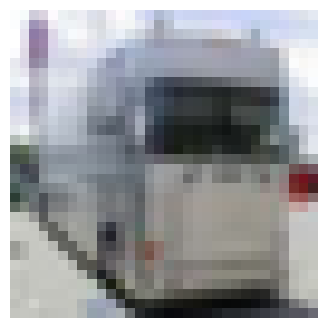

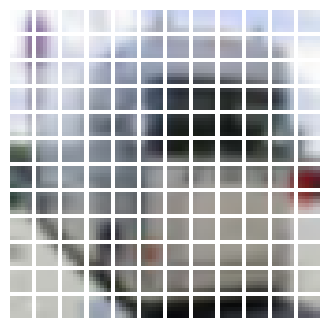

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

The following illustration describes inner working of the patch encoder.

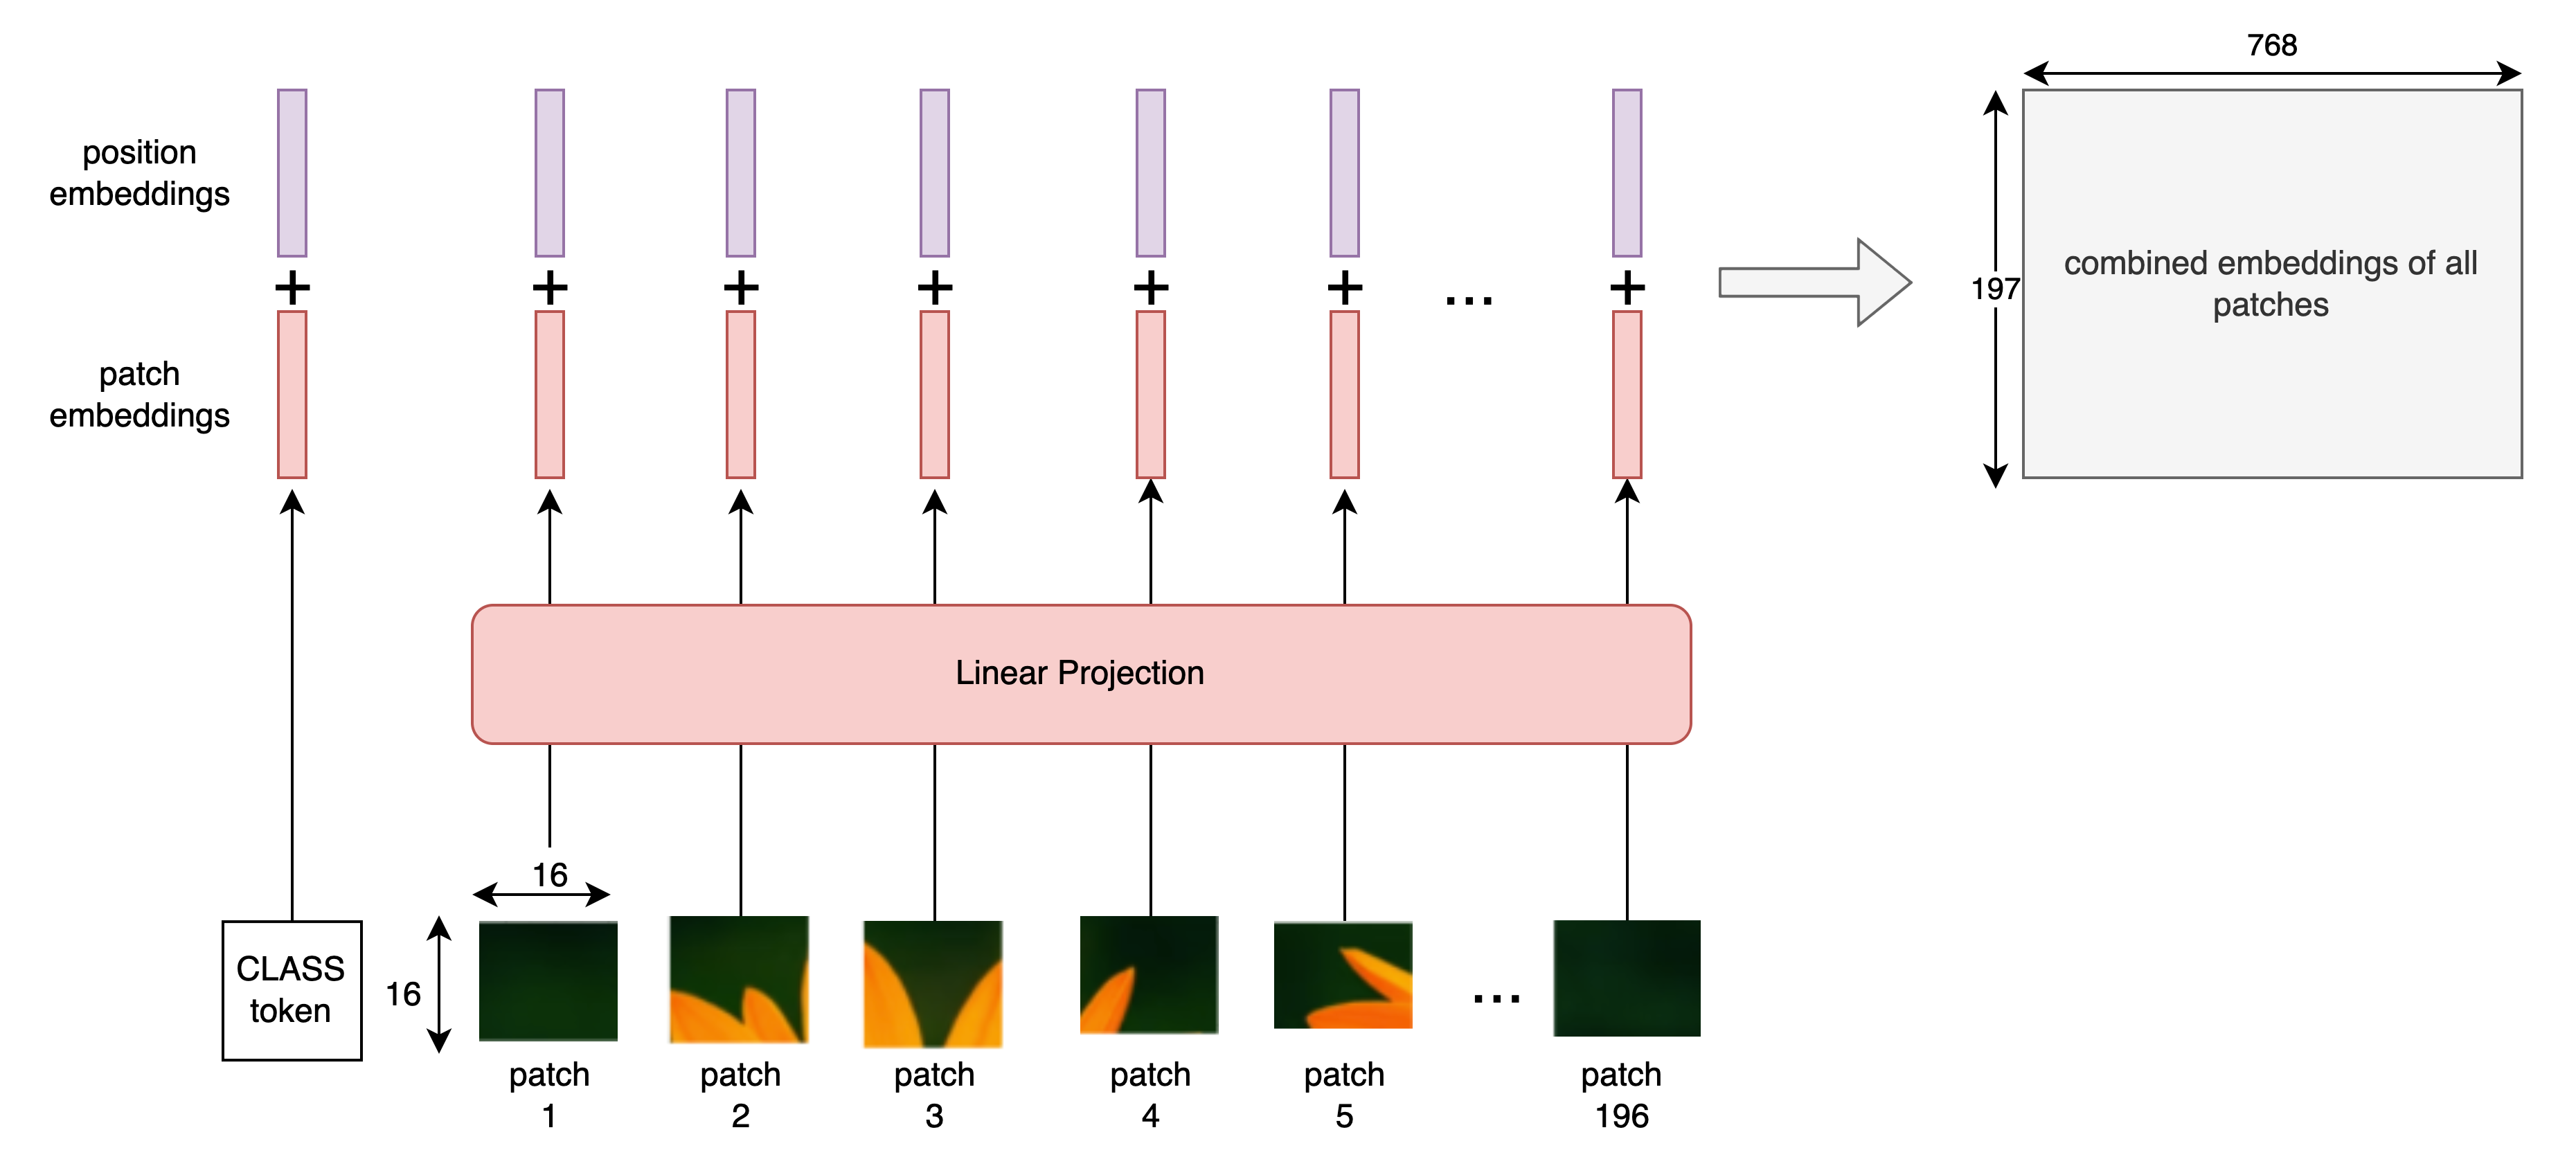

The `PatchEncoder` implementation is straightforward, we need a `Dense` layer to project a patch into a vector of size `projection_dim`, plus an `Embedding` layer to learn the positional embeddings.

If we were implementing the **ClassToken**, we would also need a trainable `tf.Variable` that will learn the `[class]` token embeddings. However, we are **not** doing that in this simple example.

Let's use a custom layer to put all this together as follows:

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Implement multilayer perceptron (MLP)

A Multilayer Perceptron (MLP) consists basically of `k` dense layers with a `GELU` activation layer. It is used in the Transformer encoder as well as the final output layer of the ViT model.

We can implement it as follows:

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via a
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:
def create_vit_classifier():

    inputs = layers.Input(shape=input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Create patches.
    patches = Patches(patch_size)(augmented)

    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

We can now compile and train our model.

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
        jit_compile = True
    )

    with tf.device('/GPU:0'):
        history = model.fit(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_split=0.1,
        )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 386ms/step - accuracy: 0.0305 - loss: 4.8891 - top-5-accuracy: 0.1146 - val_accuracy: 0.1010 - val_loss: 3.9712 - val_top-5-accuracy: 0.2934
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 381ms/step - accuracy: 0.0863 - loss: 4.0006 - top-5-accuracy: 0.2694 - val_accuracy: 0.1560 - val_loss: 3.6074 - val_top-5-accuracy: 0.4032
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 384ms/step - accuracy: 0.1276 - loss: 3.7349 - top-5-accuracy: 0.3555 - val_accuracy: 0.1912 - val_loss: 3.4213 - val_top-5-accuracy: 0.4542
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.1527 - loss: 3.5715 - top-5-accuracy: 0.4051 - val_accuracy: 0.2232 - val_loss: 3.2470 - val_top-5-accuracy: 0.5032
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.1756 - loss: 3.4120 - top-5-accuracy: 0.4510 - val_accuracy: 0.2432 - val_loss: 3.1023 - val_top-5-accuracy: 0.5354
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 381ms/step - accuracy: 0

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions.
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices,
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.